## Zaawansowane sieci neuronowe

Proste sieci neuronowe są w stanie (jak Państwo widzieli) rozwiązywać nawet bardzo złożone problemy klasyfikacji i aproksymacji przy stosunkowo niewielkim nakładzie pracy ich twórcy (np. w stosunku do wykorzystania metod numerycznych), jednak do najbardziej złożonych zadań potrzebne są sieci specjalnie zaprojektowane do rozwiązywania tych problemów.

## Sieci konwolucyjne

W wypadku zwykłej sieci neuronowej, przetwarzamy obraz przez pocięcie go na kawałki i podanie jako sekwencję wartości, często bardzo dużą i nieuporządkowaną. W rzeczywistości w wypadku grafiki sąsiedztwo pikseli ma bardzo istotne znaczenie (wykrywanie krawędzi, szumów, dużych jednolitych plam barwnych). Sieci konwolucyjne dzielą grafikę na mniejsze części, rozpatrując je osobno za pomocą dyskretnej konwolucji.

### Historia i zastosowanie 


#### Inspiracja 
W 1959 roku neurofizjolodzy z Harvardu, David H. Hubel i Torsten Wiesel, wprowadzili mikroelektrodę do pierwotnej kory wzrokowej u znieczulonego kota. Następnie wyświetlali wzorce światła i ciemności na ekranie przed kotem i odkryli, że niektóre neurony aktywowały się szybko, gdy były prezentowane linie pod jednym kątem, podczas gdy inne reagowały najlepiej pod innym kątem. Nazwali te neurony „prostymi komórkami”. Jeszcze inne neurony, które nazwali „komórkami złożonymi”, najlepiej reagowały na linie poruszające się pod pewnym kątem w jednym kierunku. 

![CatexperimentUrl](https://www.researchgate.net/profile/David-Berga/publication/337360115/figure/fig4/AS:826941796012034@1574169696239/Left-Experimental-setup-from-Hubel-Wiesel-136-137-adapted-from-253-Chapter-11.ppm "catexperiment")

Badania te pokazały, w jaki sposób system wzrokowy buduje obraz z prostych bodźców w bardziej złożone reprezentacje. Wiele sztucznych sieci neuronowych można obecnie postregać jako te będące inspirowane badaniami Hubela i Wiesela. 

"Oficjalnie" konwolucyjne sieci neuronowe, zwane również ConVNet **(CNN), zostały po raz pierwszy wprowadzone w latach 80**. przez Yanna LeCuna, francuskiego badacza, pracującego obecnie na Courant Institute of Mathematical Sciences na Uniwersytecie Nowojorskim. 


#### Zastosowanie

- przetwarzanie obrazów i wideo, 
- przetwarzanie języka naturalnego (NLP),
- systemy rekomendacyjne.

Poniżej zaprezentowano schemat architektury oraz uczenia konwolucyjnej sieci neuronowej.

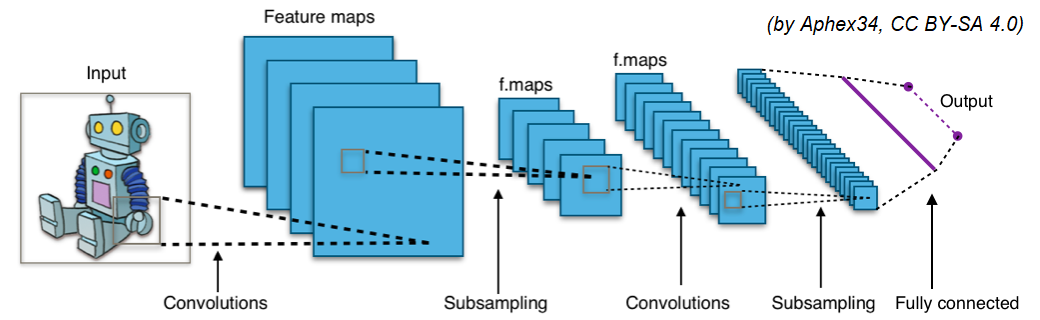

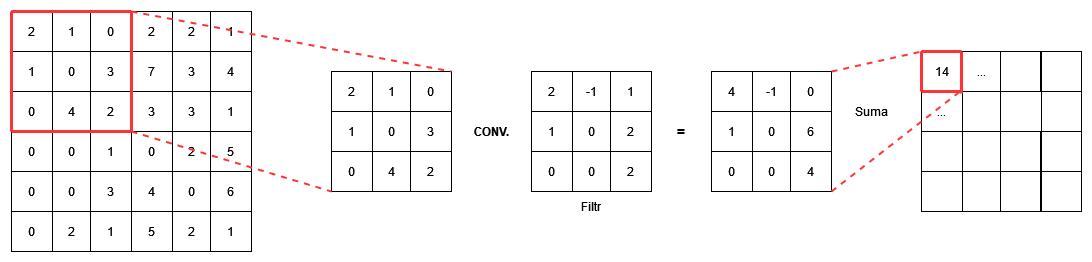

#### Zalety sieci konwolucyjnych:


* Dokonują wysokopoziomowej ekstrakcji cech
* Uczą się szybciej i wymagają mniejszych struktur również dla znacznie większych rozdzielczości i ilości kanałów

## Pakiet PyTorch

PyTorch to jedno z dużych narzędzi do budowania zaawansowanych sieci neuronowych, upraszcza wiele mechanizmów i pozwala wykonywać je "pod maską", posiada też wbudowane implementacje dla wielu istniejących sieci neuronowych.

In [ ]:
import torch

# torch korzysta z tensorów, które w działaniu są podobne do arrayów z numpy:
example_tensor = torch.Tensor([[3.1,7.2,8.6],[3.0,4,-0.3]])
example_tensor

tensor([[ 3.1000,  7.2000,  8.6000],
        [ 3.0000,  4.0000, -0.3000]])

In [ ]:
# pobierzmy zbiór irysów, najłatwiej jest to zrobić w sklearnie, więc z niego skorzystajmy:

import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

iris = load_iris()
X = iris['data']
y = iris['target']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify = y, test_size=0.2)

In [ ]:
# mamy już zbiory. Teraz zaimportujmy potrzebne nam rzeczy w torchu

import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable

# najczęściej tworzymy sieci neuronowe dziedzicząc je po klasie nn.Module. Zawiera ona wszystkie potrzebne funkcje do tworzenia uczenia sieci neuronowej.
class TorchModel(nn.Module):
  def __init__(self, input_size):
    super(TorchModel, self).__init__()
    # ustalamy kształt sieci. Weźmy 3 warstwy, w pierwszej 80 neuronów, potem 50, na wyjściu 3.
    self.layer1 = nn.Linear(input_size, 80)
    self.layer2 = nn.Linear(80, 50)
    self.layer3 = nn.Linear(50, 3)

  def forward(self, x):
    # ręcznie wpisujemy funkcję wyjścia z sieci
    x = F.relu(self.layer1(x))
    x = F.relu(self.layer2(x))
    x = F.softmax(self.layer3(x), dim=1)
    return x


model = TorchModel(X_train.shape[1])
optimizer = torch.optim.Adam(model.parameters())
loss_function = nn.CrossEntropyLoss()

# możemy obejrzeć model:
model

TorchModel(
  (layer1): Linear(in_features=4, out_features=80, bias=True)
  (layer2): Linear(in_features=80, out_features=50, bias=True)
  (layer3): Linear(in_features=50, out_features=3, bias=True)
)

In [ ]:
# możemy już przejść do faktycznego uczenia:

epochs = 200

# torch jest bardzo czuły na swoje typy. Dane wejściowe domyślnie są typu float, a wyjściowe jako long
# oczywiście torch przyjmuje też tylko swoje tensory jako wejścia i tak też zwraca wyjścia

X_train_tensor = torch.from_numpy(X_train).float()
X_test_tensor = torch.from_numpy(X_test).float()
y_train_tensor = torch.from_numpy(y_train).long()
y_test_tensor = torch.from_numpy(y_test).long()

# stwórzmy sobie listy do zapisania historii funkcji strat i dokładności klasyfikacji:
loss_history = []
accuracy_train_history = []
accuracy_test_history = []

In [ ]:
# faktyczna pętla uczenia

for epoch in range(epochs):
  # wejście przechodzi przez model
  predicted_y = model(X_train_tensor)
  # liczymy funkcję strat (entropię krzyżową)
  loss = loss_function(predicted_y, y_train_tensor)
  # zerujemy gradient optimizera, żeby nie używał gradientów skumulowanych w poprzednich epokach i przepuszczamy go przez całą sieć
  optimizer.zero_grad()
  loss.backward()
  # aktualizujemy współczynnik uczenia optimizera
  optimizer.step()
  loss_history.append(loss.item())
  # policzmy dokładność (dla danych uczących i testujących)
  # musimy użyć torch.no_grad(), żeby nasze obliczenia nie zostały zapisane jako gradienty
  with torch.no_grad():
    y_pred_train = model(X_train_tensor)
    correct_train = (torch.argmax(y_pred_train, dim=1) == y_train_tensor).type(torch.FloatTensor)
    accuracy_train_history.append(correct_train.mean())

    y_pred_test = model(X_test_tensor)
    correct_test = (torch.argmax(y_pred_test, dim=1) == y_test_tensor).type(torch.FloatTensor)
    accuracy_test_history.append(correct_test.mean())

# zobaczmy accuracy na zbiorze testowym w ostatniej epoce:
accuracy_test_history[-1]

tensor(0.9667)

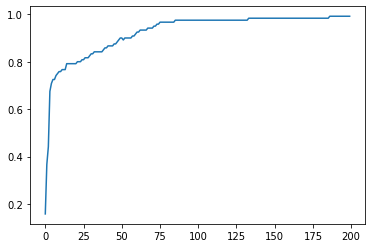

In [ ]:
import matplotlib.pyplot as plt

plt.plot(accuracy_train_history)

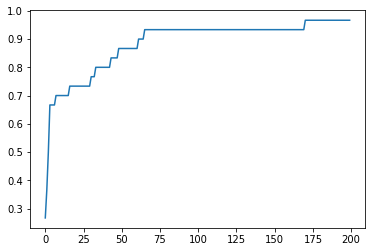

In [ ]:
plt.plot(accuracy_test_history)

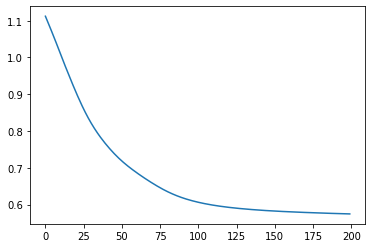

In [ ]:
plt.plot(loss_history)

## Sieci konwolucyjne


### Pojęcie konwolucji

Konwolucja (operacja splotu, mnożenie całkowe, splot całkowy) - działanie określone dla dwóch funkcji, które w wyniku daje inną funkcję.

$$h(n)= f(t)∗g(t)= \int_{-\infty}^{\infty}      f(τ) · g(t − τ)dτ $$



$$ h[n]=f[n]∗g[n]= \sum_{m = -\infty}^{\infty}f[m]·g[n−m]$$

Konwolucja na obrazach jest operacją dyskretną i zachodzi w dwóch bądź więcej wymiarach (wykonywana jest na pikselach). 

### Kernele (filtry)

Operacja konwolucji w uproszczeniu jest przekształceniem macierzowym fragmentów zdjęcia, które ma na celu wydobycie informacji o konkretnych cechach obrazu.

Przykładem takiej operacji jest stworzenie negatywu zdjęcia. Jest to po prostu przemnożenie zdjęcia przez macierz -1, co doprowadzi do odwrócenia kolorów. Wspomniana macierz nazywa się filtrem (kernelem). Dobiera się je w taki sposób aby wyciągnąć pewną informację. 

Poniżej przedstawiono sposób działania kernela o rozmiarze 3x3. 

![KernelUrl](https://miro.medium.com/v2/resize:fit:1052/1*GcI7G-JLAQiEoCON7xFbhg.gif "kernel")

#### Padding (wypełnienie)

Cechą charakterystyczną warstw konwolucyjnych jest to, że mają tendencję do gubienia pikseli na obwodzie obrazu.Piksele w rogach są prawie w ogóle nieużywane. Problem ten można rozwiązać stosując padding, czyli wypełnienie. Przykładową metodą paddingu może być dodanie "zerowych" pikseli na bokach obrazka. 

![PaddingUrl](https://d2l.ai/_images/conv-pad.svg "padding")



#### Stride (krok)

Do liczby wierszy i kolumn o które przesuwamy filtr odnosimy się jako krok ("stride"). Najprostszym zabiegiem jest użycie kroku 1. Możliwe jest jednak zastosowanie kroku o większej wartości. 

![StrideUrl](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*y3Ydr1oCHRfOegWxZITIOA.png "stride")



In [ ]:
# implementacja operacji konwolucji

'''
torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0)
'''
in_channels = 2
out_channels = 3
kernel_size = 2
conv = nn.Conv2d(in_channels, out_channels, kernel_size)

# conv = nn.Conv2d(2, 3, 2)

'''
# oznaczenie NCHW
# N - ilość zdjęć
# C - ilość kanałów jednego zdjęcia
# H - wysokość jednego zdjęcia
# W - szerokość jednego zdjęcia
'''

# zdefiniowanie inputu
N=2
C=2
H=4
W=4
input = torch.empty(N,C,H,W).random_(256)
print("Input Tensor:", input)
print("Input Size:",input.size())

# operacja konwolucji
output = conv(input)
print("Output Tensor:", output)
print("Output Size:",output.size())

# z zastosowaniem filtra, tzw. kernela

# z kernelem wejściowym (2,2) oraz krokiem 2
conv = nn.Conv2d(2, 3, 2, stride=2)
output = conv(input)
print("Output Size:",output.size())

# z kernelem wejściowym (2,2) oraz krokiem 2 i paddingiem
conv = nn.Conv2d(2, 3, 2, stride=2, padding = 1)
output = conv(input)
print("Output Size:",output.size())

Input Tensor: tensor([[[[211.,  99., 208.,  90.],
          [119., 198.,   3., 231.],
          [  8.,  83.,  29., 107.],
          [243., 250., 151.,  41.]],

         [[ 89., 197.,  58.,  32.],
          [  0., 156.,  80., 225.],
          [ 36.,   8., 186.,  33.],
          [208., 185.,   1.,   0.]]],


        [[[183.,  92.,  37.,  34.],
          [112., 170., 157., 253.],
          [166.,  61., 208.,  26.],
          [187., 111.,  73., 211.]],

         [[  6.,  72.,  52.,  69.],
          [ 22., 130., 147.,  98.],
          [  1.,  99., 199., 168.],
          [107.,  98., 139., 181.]]]])
Input Size: torch.Size([2, 2, 4, 4])
Output Tensor: tensor([[[[  89.2060,   81.3998,    5.5971],
          [  42.8285,   46.2335,   72.8612],
          [  49.9817,   86.2158,   91.9659]],

         [[  83.2932,  101.8983,   94.7038],
          [  44.5925,   64.0918,   41.7903],
          [ 131.6954,   60.1919,   38.2909]],

         [[ -21.7211,  -54.8282,  -66.1237],
          [  24.2014, -100.7

#### Powyższe operacje warto przedstawić na realnym obrazku

In [ ]:
# pobranie z sieci obrazka kotka rudego (Prionailurus rubiginosus)
import urllib.request

urllib.request.urlretrieve(
  'https://orientarium.lodz.pl/assets/2022/02/kotek-rudy-591x601.jpg',
   "kot_rudy.png")

('kot_rudy.png', <http.client.HTTPMessage at 0x7fc9c2628790>)

Przed działaniem filtra


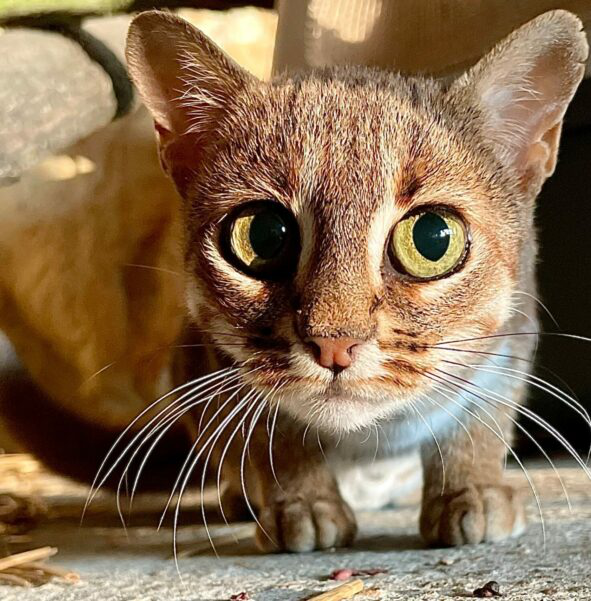

Input image size: torch.Size([3, 601, 591])
Po działaniu filtra


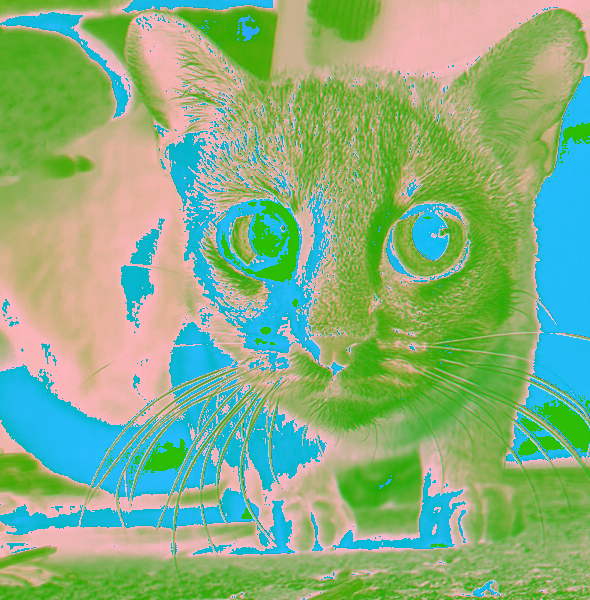

In [ ]:
# potrzebne importy
import torch
import torchvision
from PIL import Image
import torchvision.transforms as T

# wczytanie obrazka
print('Przed działaniem filtra')
img = Image.open('kot_rudy.png')
img.show()
# przekształcenie w torch tensor
img = T.ToTensor()(img)
print("Input image size:", img.size())

# przekształcenie na tensor 4D
img = img.unsqueeze(0) 
# zdefiniowanie warstwy konwolucyjnej
'''conv = nn.Conv2d(in_channels, out_channels, kernel_size)'''
conv = torch.nn.Conv2d(3, 3, 2)

# zaaplikowanie konwolucji na obrazku
img = conv(img)

# przekształcenie na 3D
img = img.squeeze(0) 

# przekształcenie formatu
img = T.ToPILImage()(img)

# wyświetlenie obrazu kota
print('Po działaniu filtra')
img.show()

# należy pamiętać, że z każdą inicjalizacją plik może być inny ze względu na różne inicjalne wagi i biasy

### Pooling (subsampling)

Najbardziej popularnym rodzajem poolowania jest Max Pooling. Jest to operacja, która oblicza maksymalną wartości z wyliczonej już w warstwie konwolucyjnej mapy obiektów. Jest standardowo używany właśnie po warstwie splotu. 

Celem operacji poolingu jest stopniowe zmniejszanie rozmiaru obrazu, co zmniejsza liczbę parametrów do wytrenowania. Oznacza to więc, że sieć trenuje się krócej. 

![maxpoolUrl](https://lh3.googleusercontent.com/hpsr13DyQ9N7fWvXH--YvJgeALOHkwbT3aH7CUc0_b47uW9dQ5y2lsIoep9Y0MOkMjYcxv3yxhdf4_11SmHFfxKTCv-83OY0eJ8laKa6QKCr7iuJx5FKx1JSOQW551WijVuc3x72ear2euMT "maxpool")


Idea poolingu polega na tym, że kilka pikseli np. rozmiar 2×2 mapujemy na 1 piksel. 

In [ ]:
# wygenerowanie danych wejściowych
input = torch.empty(3, 4, 4).random_(256)
print("Input Tensor:", input)
print("Input Size:",input.size())

# operacja Max pool - rozmiar=3, krok=1
pooling1 = nn.MaxPool2d(3, stride=1)

# operacja MaxPool
output = pooling1(input)
print("Output Tensor:", output)
print("Output Size:",output.size())

Input Tensor: tensor([[[113.,  91., 151., 141.],
         [190.,  60., 122., 180.],
         [151.,   3., 105.,  68.],
         [ 92., 110., 110.,   3.]],

        [[156., 159., 143.,  98.],
         [172.,  50., 117., 140.],
         [226., 110., 122., 105.],
         [208., 139., 207., 211.]],

        [[230., 149.,   8.,  57.],
         [199., 249.,  31.,  32.],
         [172., 130., 237., 162.],
         [ 82., 101.,  64., 172.]]])
Input Size: torch.Size([3, 4, 4])
Output Tensor: tensor([[[190., 180.],
         [190., 180.]],

        [[226., 159.],
         [226., 211.]],

        [[249., 249.],
         [249., 249.]]])
Output Size: torch.Size([3, 2, 2])


Original size of Image: torch.Size([3, 601, 591])
Size after MaxPool: torch.Size([3, 598, 588])


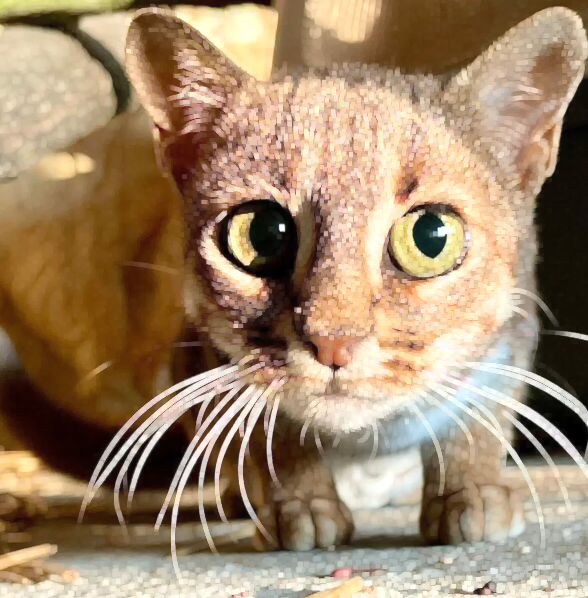

In [ ]:
import torchvision.transforms as T

# wczytanie obrazka
img = Image.open('kot_rudy.png')

# przekształcenie w torch tensor
img = T.ToTensor()(img)
print("Original size of Image:", img.size())

# przekształcenie na tensor 4D
img = img.unsqueeze(0)

# zdefiniowanie max pool z oknem size=4 i stride=1
pool = torch.nn.MaxPool2d(4, 1)
img = pool(img)
img = img.squeeze(0)
print("Size after MaxPool:",img.size())
img = T.ToPILImage()(img)
img.show()

**Poniżej zaprezentowano przykład uczenia konwolucyjnej sieci neuronowej za pomocą prezentowanego powyżej frameworka.**

Zbiór danych CIFAR-10 składa się z 60000 kolorowych obrazów 32x32 w 10 klasach, po 6000 obrazów w każdej klasie. 

Istnieje 50000 obrazów uczących i 10000 obrazów testowych.

In [ ]:
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

#zawartość obrazków - klasy
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


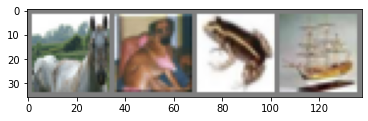

horse dog   frog  ship 


In [ ]:
# funkcja do prezentacji obrazków

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# wybranie losowych obrazów
dataiter = iter(trainloader)
images, labels = next(dataiter)

# prezentacja obrazka
imshow(torchvision.utils.make_grid(images))
# prezentacja labeli
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [ ]:
#zdefiniowanie sieci konwolucyjnej

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [ ]:
#definiowanie funkcji straty i optymizera

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
#uczenie sieci
for epoch in range(2): 

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # pobranie danych
        inputs, labels = data

        # ustawienie wszystkich optymalizowanych gradientow na zero
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # wydrukowanie statystyk
        running_loss += loss.item()
        if i % 2000 == 1999:    # wydrukowanie wynikow co 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Trening ukończony')

[1,  2000] loss: 2.187
[1,  4000] loss: 1.824
[1,  6000] loss: 1.687
[1,  8000] loss: 1.572
[1, 10000] loss: 1.503
[1, 12000] loss: 1.451
[2,  2000] loss: 1.395
[2,  4000] loss: 1.361
[2,  6000] loss: 1.341
[2,  8000] loss: 1.320
[2, 10000] loss: 1.284
[2, 12000] loss: 1.269
Finished Training


## Zadania do samodzielnego wykonania

1.

Proszę pobrać zbiór fasion MNIST (torchvision.datasets.FashionMNIST) i zaproponować sieć konwolucyjną do jego klasyfikacji. Dla co najmniej trzech architektur proszę wypisać macierz pomyłek i wykresy funkcji strat podczas uczenia. Proszę spróbować w każdym wypadku podać przynajmniej jeden źle zaklasyfikowany obrazek.

_Proszę pamiętać, że zadanie może wymagać odpowiedniego czasu na obliczenia. Nie polecamy wykonywać go na komputerach uczelnianych, tylko wykorzystać zasoby colaba (albo własne, jeśli państwo chcą). Ewentualne przyśpieszenie obliczeń można uzyskać korzystając z GPU w colabie, jeżeli nie dysponują państwo kartą NVidii albo nie chcą jej państwo używać (opisane w zadaniu 2*)_

## Zadania dla chętnych

2*.

Dla zainteresowanych - proszę dowiedzieć się więcej o tym, jak działają obliczenia na kartach graficznych w torchu. Będą państwo potrzebowali funkcji __torch.Tensor.to()__ (https://pytorch.org/docs/stable/generated/torch.Tensor.to.html). Do sprawdzenia, czy CUDA są dostępne na urządzeniu, można użyć funkcji __torch.cuda.is_available()__ (https://pytorch.org/docs/stable/generated/torch.cuda.is_available.html) i __torch.cuda.get_device_name()__ (https://pytorch.org/docs/stable/generated/torch.cuda.get_device_name.html)

Żeby móc wykonać poniższy kod poprawnie w colabie, muszą państwo kliknąć Runtime->Change Runtime Type i wybrać GPU jako hardware accelerator.

In [ ]:
print('Czy mam CUDA?', torch.cuda.is_available() )

x = torch.cuda.current_device() # zwraca ID urządzenia
print('Nazwa GPU x:',torch.cuda.get_device_name(x))

print('Wersja CUDNN:', torch.backends.cudnn.version())
print('Ilość urządzeń CUDA:', torch.cuda.device_count())
print('Nazwa urządzenia CUDA: ',torch.cuda.get_device_name(0))
print('Pamięć urządzenia CUDA [GB]:',torch.cuda.get_device_properties(0).total_memory/1e9)

Czy mam CUDA? True
Nazwa GPU x: Tesla T4
Wersja CUDNN: 8302
Ilość urządzeń CUDA: 1
Nazwa urządzenia CUDA:  Tesla T4
Pamięć urządzenia CUDA [GB]: 15.835398144


3*.

Dla zainteresowanych - proszę doczytać o mechanizmie dropoutu (https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html, https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/) i spróbować zastosować mechanizm dropoutu do stworzonej sieci neuronowej.

Przydatne linki: 

https://www.cs.toronto.edu/~kriz/cifar.html

